# Tensorboard
Kode ini bersumber dari modul [Feed Forward](/14_feedforward.ipynb/) dan untuk modul tensorboard ini, kita akan memodifikasi notebook ini. Setiap penambahan yang berbeda pada modul ini dibandingkan modul feedforward akan ditandai dengan menambahkan komentar.

## Persiapan
Sebelum memulai modul ini, anda harus menginstall tensorboard. Berikut perintah yang perlu anda ketikkan di terminal untuk menginstall tensorboard:

**Jika anda menggunakan conda sebagai package manager anda:**
```terminal
conda install -c conda-forge tensorboard
```

**Jika anda tidak menggunakan conda**
```terminal
pip install tensorboard
```

## Menjalankan Tensorboard
Untuk menjalankan tensorboard, anda dapat mengetikkan perintah di bawah ini melalui terminal:

```terminal
tensorboard --logdir=runs
```
Anda dapat mengganti ```runs``` dengan path tensorboard anda apabila anda merasa bahwa tensorboard anda tidak diinstal pada direktori default. Sesudah perintah diatas diketikkan maka akan terdapat url localhost dan port yang dapat digunakan untuk menjalankan tensorboard. Anda dapat mengklik url tersebut sehingga tensorboard terbuka di browser anda. Pada tahap ini, tensorboard memang tidak akan berjalan karena kita belum menjalankan apapun pada program.

Anda dapat mengabaikan keterangan ```TensorFlow installation not found - running with reduced feature set.``` karena memang kita tidak sedang menggunakan tensorflow.

In [49]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


**Mengimpor Tensorboard**
- tensorboard diimpor dengan menggunakan ```from torch.utils.tensorboard import SummaryWriter```
- Selanjutnya kita akan menggunakan ```SummaryWriter``` untuk menulis data ke tensorboard
- Kita membuat sebuah variabel bernama ```writer``` dan kita masukan ```SumaryWriter``` ke dalamnya beserta informasi terkait path dimana data tensorboard akan disimpan.
- Kita juga membutuhkan import sys

In [50]:
import sys
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("../runs/mnist4")

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.01

In [53]:
train_dataset = torchvision.datasets.MNIST(root='../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data',
                                           train=False,
                                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

Ukuran sample: torch.Size([100, 1, 28, 28])
Ukuran label: torch.Size([100])


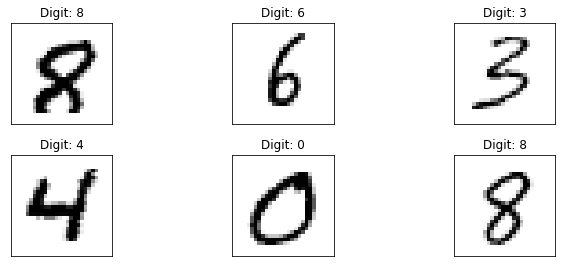

In [54]:
example_batch = iter(train_loader)
samples, labels = example_batch.next()
print(f'Ukuran sample: {samples.shape}')
print(f'Ukuran label: {labels.shape}')

# show 6 samples image with label using subplot
fig = plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(samples[i][0], cmap='gist_yarg')
    plt.title("Digit: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

**Membuat image grid untuk tensorboard**
- Kita membuat sebuah variabel ```sample_grid``` untuk menampung data gambar yang akan ditampilkan pada tensorboard.
- ```writer.add_image``` adalah sebuah method yang digunakan untuk mengirimkan data gambar ke tensorboard.
- ```writer.close()``` adalah sebuah method yang digunakan untuk menutup koneksi ke tensorboard.

In [55]:
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('Image_Grid_MNIST', img_grid)
writer.close()

**Menjalankan Tensorboard**
- Untuk menjalankan tensorboard, buka terminal dan pindah ke direktori dari repositori ini (pengantarDLpytorch)
- Setelah program ini dijalankan, akan terbentuk folder baru bernama 'runs' (sesuai dengan path pada writer)
- Jalankan tensorboard dengan mengetikkan ```tensorboard --logdir=runs``` (apabila path anda berbeda, silahkan disesuaikan)

In [56]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Membuat model graph untuk tensorboard**
- Perintah yang digunakan adalah ```writer.add_graph```
- ```writer.add_graph``` adalah sebuah method yang digunakan untuk mengirimkan grafik model ke tensorboard.
- Data sampel yang kita berikan ke writer haruslah direshape terlebih dahulu

In [58]:
writer.add_graph(model, samples.reshape(-1, 28*28))
writer.close()

Setelah menjalankan bagian diatas, dapat kita amati bahwa terdapat tab baru pada tensorboard yang berjudul 'Graph'. (silahkan refresh halaman untuk melihat perubahan). Anda dapat membuka tab tersebut dan melakukan dobel-klik pada tulisan ```neural_net``` untuk melihat grafik model.

In [59]:
n_total_step = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_step}], Loss: {loss.item():.4f}')
            writer.add_scalar('Training Loss', running_loss / 100, epoch * n_total_step + i)
            writer.add_scalar('Accuracy', running_correct / 100, epoch * n_total_step + i)
            running_loss = 0.0
            running_correct = 0

Epoch [1/2], Step [100/600], Loss: 0.2642
Epoch [1/2], Step [200/600], Loss: 0.1133
Epoch [1/2], Step [300/600], Loss: 0.3417
Epoch [1/2], Step [400/600], Loss: 0.1487
Epoch [1/2], Step [500/600], Loss: 0.1137
Epoch [1/2], Step [600/600], Loss: 0.0531
Epoch [2/2], Step [100/600], Loss: 0.1755
Epoch [2/2], Step [200/600], Loss: 0.0391
Epoch [2/2], Step [300/600], Loss: 0.3811
Epoch [2/2], Step [400/600], Loss: 0.0682
Epoch [2/2], Step [500/600], Loss: 0.1405
Epoch [2/2], Step [600/600], Loss: 0.1072


**Running Loss & Running Correct**
Pada bagian training loop ditambahkan beberapa hal seperti:
- ```running_loss += loss.item()``` untuk menghitung loss per step
- ```running_correct += (predicted == labels).sum().item()``` untuk menghitung jumlah benar per step
- ```writer.add_scalar('Training Loss', running_loss / 100, epoch * n_total_step + i)``` untuk mengirimkan loss ke tensorboard
- ```writer.add_scalar('Accuracy', running_correct / 100, epoch * n_total_step + i)``` untuk mengirimkan accuracy ke tensorboard
- ```running_loss = 0.0``` untuk mengosongkan running loss
- ```running_correct = 0``` untuk mengosongkan running correct

In [60]:
labels = []
preds = []


with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, ylabels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        ylabels = ylabels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += ylabels.size(0)
        n_correct += (predicted == ylabels).sum().item()

        class_prediction = [F.softmax(outputs, dim=0) for outputs in outputs]
        preds.append(class_prediction)
        labels.append(predicted)

    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels = torch.cat(labels, dim=0)

    accuracy = 100.0 * n_correct / n_samples
    print(f'Akurasi: {accuracy}')

    classes = range(10)
    for i in classes:
        labels_i = labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

Akurasi: 96.52
